# Lecture 21: Hidden Markov Models and Robot Localization
***

        
<img src="figs/robot_banner.png",width=1000,height=50>        

In [174]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from random import choice 

msize = 200
myfigsize=(12,6)

mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}

class RobotWorld:
    def __init__(self, board=[(0,0)], pos=(0,0), eps=0.05):
        self.board=board
        self.pos=pos
        self.probs=np.ones(len(self.board))/len(self.board)
        self.sensor = [0,0,0,0]
        self.emissions = np.zeros(len(self.board))
        self.eps=eps
        self.T = self.get_transition()
        
    def get_transition(self):
        T = np.zeros((len(self.board), len(self.board)))
        for ii, sq in enumerate(self.board):
            neighbors = self.get_neighbors(pos=sq)
            valid_neighbors = [jj for jj, n in enumerate(self.board) if n in neighbors]
            t = 1.0 / len(valid_neighbors)
            for jj in valid_neighbors:
                T[ii,jj] = t 
            
        return T
    
    def get_emissions(self):
        self.take_reading()
        for ii, sq in enumerate(self.board):
            ith_reading = self.take_reading(fuzzy=False, pos=sq)
            wrong = 0
            for r, t in zip(ith_reading, self.sensor):
                if r!=t:
                    wrong += 1
            self.emissions[ii] =  ((1-self.eps)**(4-wrong))*(self.eps**wrong)
        
    def get_neighbors(self, pos=None):
        pos = pos if pos else self.pos 
        directions = [(0,1), (0,-1), (1,0), (-1,0)] # N, S, E, W
        return [tuple(p+d for p, d in zip(pos, d)) for d in directions]
    
    def move(self):
        neighbors = self.get_neighbors()
        valid_moves = [n for n in neighbors if n in self.board]
        self.pos = choice(valid_moves)
        
    def take_reading(self, fuzzy=True, pos=None):
        
        pos = pos if pos else self.pos
        
        neighbors = self.get_neighbors(pos) if pos else self.get_neighbors()
        reading = [0]*4
        for ii, neighbor in enumerate(neighbors): 
            true_reading = 1 if neighbor in self.board else 0
            if fuzzy: 
                reading[ii] = true_reading if np.random.uniform() <= (1-self.eps) else 1-true_reading 
            else: 
                reading[ii] = true_reading 
                
        if fuzzy:
            self.sensor = reading 
        else:
            return reading 
                
    def draw(self):
        
        # Get board limits 
        mxx = max([ii for ii, jj in self.board])
        mxy = max([jj for ii, jj in self.board])
        
        # Draw board 
        fig = plt.figure(figsize=(2*mxx,2*mxy))
        ax = fig.add_subplot(111, aspect='equal')
        
        # Draw Squares 
        for ii, sq in enumerate(self.board):
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=1, edgecolor="black", fill=None))
            ax.add_patch(patches.Rectangle(sq, 1, 1, lw=0, facecolor="black",alpha=self.probs[ii]))
            
        # Draw Robot 
        ax.add_patch(patches.Circle((self.pos[0]+.5, self.pos[1]+.5), .3, lw=0, color=mycolors["red"]))
        
        # Draw Sensors 
        self.take_reading()
        rcolors=[mycolors["red"] if reading==0 else mycolors["green"] for reading in self.sensor]
        ax.plot([self.pos[0]+.5, self.pos[0]+.5], [self.pos[1]+.8, self.pos[1]+1.1], lw=3, color=rcolors[0])
        ax.plot([self.pos[0]+.5, self.pos[0]+.5], [self.pos[1]+.2, self.pos[1]-0.1], lw=3, color=rcolors[1])
        ax.plot([self.pos[0]+.8, self.pos[0]+1.1], [self.pos[1]+.5, self.pos[1]+0.5],lw=3, color=rcolors[2])
        ax.plot([self.pos[0]+.2, self.pos[0]-.1], [self.pos[1]+.5, self.pos[1]+0.5], lw=3, color=rcolors[3])
            
        # TODO - Add colorbar 
            
        # Make pretty     
        ax.set_xlim(-1,mxx+4)
        ax.set_ylim(-1,mxy+2)
        plt.xticks([], fontsize=16)
        plt.yticks([], fontsize=16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    def forward(self, ipos=None, num_moves=20, draw_all=False):
            
        self.pos = ipos if ipos else self.pos 
            
        # Draw initial state no matter what 
        self.draw()
        
        f = np.ones(len(self.board)) / len(self.board)
        for ii in range(num_moves):
            self.move()
            self.get_emissions()
            af = np.multiply(self.emissions, np.dot(self.T.T, f))
            f = af / np.sum(af)
            self.probs = f 
            # Only draw intermediate state if option 
            if (ii != num_moves-1) and draw_all: 
                self.draw()
        
        # Draw final state no matter what 
        self.draw()
        

The following code builds and displays the board, along with a possible robot location. 

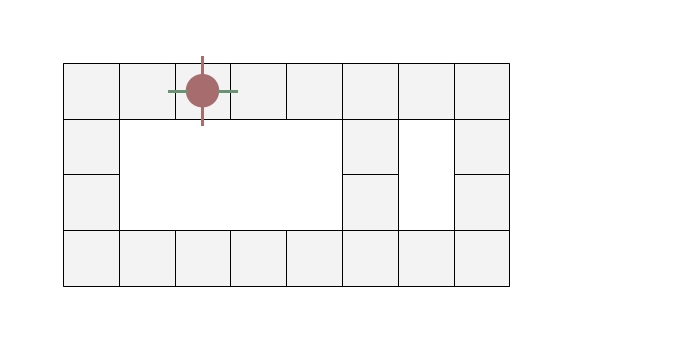

In [166]:
board_squares =  [(ii,0) for ii in range(8)]
board_squares += [(ii,3) for ii in range(8)]
board_squares += [(0,jj) for jj in range(1,3)]
board_squares += [(5,jj) for jj in range(1,3)]
board_squares += [(7,jj) for jj in range(1,3)]

rw = RobotWorld(board=board_squares, pos=(2,3), eps=0.0)
rw.draw()

The following code reinitializes the board, and then runs the Forward Algorithm to try to predict the robot's location. Currently $\epsilon$ is set to zero, so that sensor readings are always accurate.  Run it once with perfect readings, then change $\epsilon$ to some number between $0.05$ and $0.20$ and run the Forward Algorithm again. 

In [ ]:
sensor_eps = 0.00
np.random.seed(1254)
rw = RobotWorld(board=board_squares, pos=(2,3), eps=sensor_eps)
rw.forward(num_moves=20, draw_all=True)